# Social Media Data Analysis
### ray zhao

This is a glimpse into how I like to approach data analysis problems and my workflow. I hope it'll be of useful insight to you during the hiring process

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.3)

This is how I loaded and cleaned the data. I renamed the columns to all single-worded keywords that were more clear and succinct, and did the same for the social media platforms. I also created a new `rate`, `day`, and `hour` columns for use in some of the analyses down the line. I also filtered the dataset down to all values within the 1.0 threshold to make the visualizations more scaled.

In [82]:
# importing data
df = pd.read_excel('data/social_data.xlsx', engine='openpyxl')
new_column_names = ['date', 'account', 'platform', 'campaign', 'impressions', 'engagements', 'media']
platform_names = {'fbpage': 'fb', 'tiktok_business': 'tiktok', 'linkedin_company': 'linkedin'}

df = df.rename(columns=dict(zip(df.columns, new_column_names)))
df['platform'] = df['platform'].str.lower().replace(platform_names)
df['account'] = df['account'].str.lower().str.strip()
df['rate'] = (df['engagements'] / df['impressions']).fillna(0)
df['day'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

df = df[df['rate'] <= 1.0]

To first get an idea of how our posts and media perform generally, let's first take a look at how our posts across all platforms tend to perform:

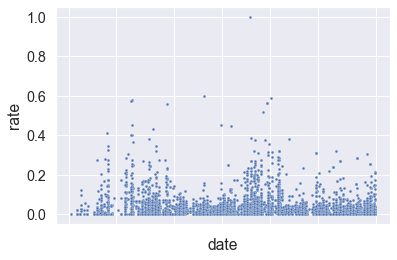

In [83]:
gen_scatter = sns.scatterplot(data=df[df['rate'] <= 1.0], x='date', y='rate', s=8).set(xticklabels=[])

While we get a good number of posts above 0.2 and even some over 0.4, we can break all this down to find the average engagement rate of all these posts as well as which percent can shoot above a 15% engagement rate.

In [84]:
print(f"the overall average engagement rate: {np.around(df['rate'].mean(), 2)}")
print(f"the likelihood we achieve a 15% engagement rate: {np.around(((df['rate'] >= 0.15).sum() / df.shape[0]), 2)}")

the overall average engagement rate: 0.04
the likelihood we achieve a 15% engagement rate: 0.06


These statistics get more interesting when we break the numbers down by social media platform. I've highlighted all the posts that broke 15% in green, and we can see how disparity there is between platforms. Facebook seems to have a sizable plorablity of posts reaching that threshold alongside Instagram with at least some portion, while the others lack a lot of engagement numbers.

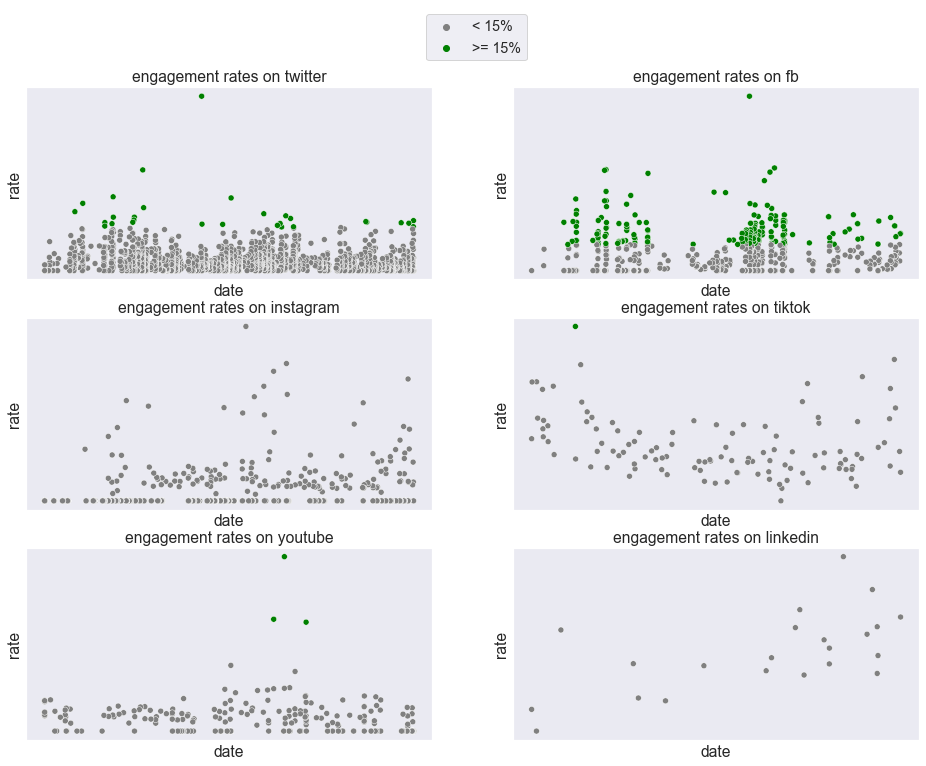

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()
palette = {'>= 15%': 'green', '< 15%': 'grey'}
for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	cmap = np.where(dfd['rate'] >= 0.15, '>= 15%', '< 15%')
	axe = sns.scatterplot(data=dfd, x='date', y='rate', hue=cmap, palette=palette, ax=ax)
	axe = ax.get_legend().remove()
	axe = ax.set_title(f"engagement rates on {platform}")
	axe = ax.set_xticks([])
	axe = ax.set_yticks([])
handles, labels = axes[0].get_legend_handles_labels()
ll = fig.legend(handles, labels, loc=(0.46, 0.92))

We can condense and quantify these to compare average engagement rates across platforms:

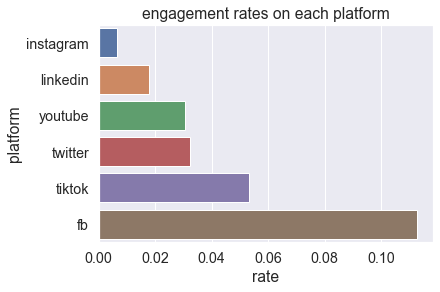

In [86]:
rate_bar = sns.barplot(
    data=df,
    y='platform',
    x='rate',
    order=df.groupby('platform').mean()['rate'].sort_values().reset_index()['platform'],
    ci=None
).set(title='engagement rates on each platform')

We'll explore these numbers and the differences between social channels more in depth a little later, when we determine a posting strategy for our channels.

For now, let's look at the other metrics and how they coalesce around engagement rates. Here's a visualization of how engagement rates shift through the week for particular days:

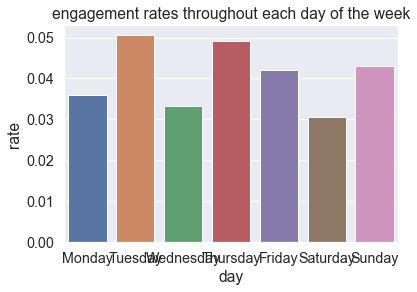

In [87]:
ordering = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot = sns.barplot(
    data=df, x='day', y='rate', order=ordering, ci=None
).set(title='engagement rates throughout each day of the week')

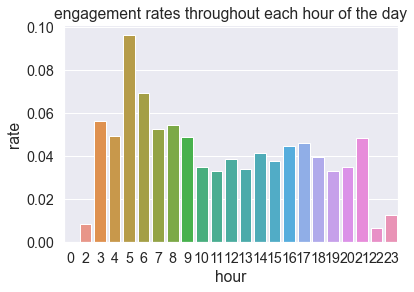

In [88]:
plot = sns.barplot(
    data=df, x='hour', y='rate', ci=None
).set(title='engagement rates throughout each hour of the day')

We can see that content posted on Mondays, Wednesdays, and Saturdays typically perform worse than those posted other days, and that conent posted in the early morning tend to perform the best, with some peaks during lunch and dinner hours.

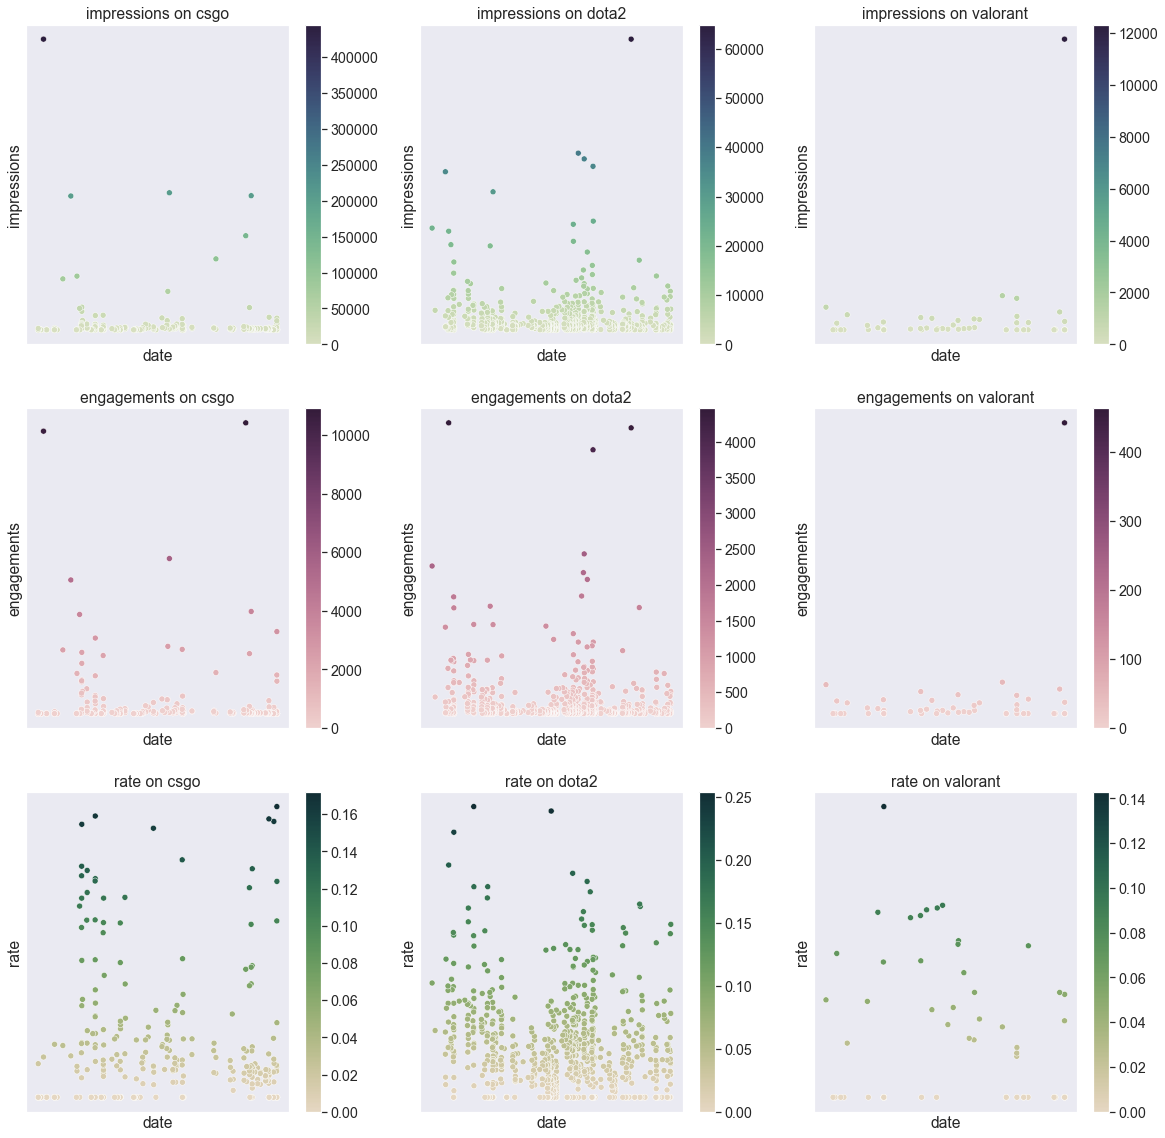

In [89]:

games = ['csgo', 'dota2', 'valorant']
metrics = ['impressions', 'engagements', 'rate']
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
cmappings = (0.5, 0.75), (0.2, -0.3), (-0.2, 0.6)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for x_ax, metric, cmapping in zip(axes, metrics, cmappings):
	cmap = sns.cubehelix_palette(start=cmapping[0], rot=-cmapping[1], as_cmap=True)
	for game, ax in zip(games, x_ax):
		dfd = df[df['account'] == game]
		plot = sns.scatterplot(data=dfd, x='date', y=metric, hue=metric, palette=cmap, ax=ax)
		norm = plt.Normalize(dfd[metric].min(), dfd[metric].max())
		sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
		axe = ax.get_legend().remove()
		axe = ax.figure.colorbar(sm, ax=ax)
		axe = ax.set_title(f"{metric} on {game}")
		axe = sm.set_array([])
		axe = ax.set_xticks([])
		axe = ax.set_yticks([])
		axe = ax.set_yticks([])

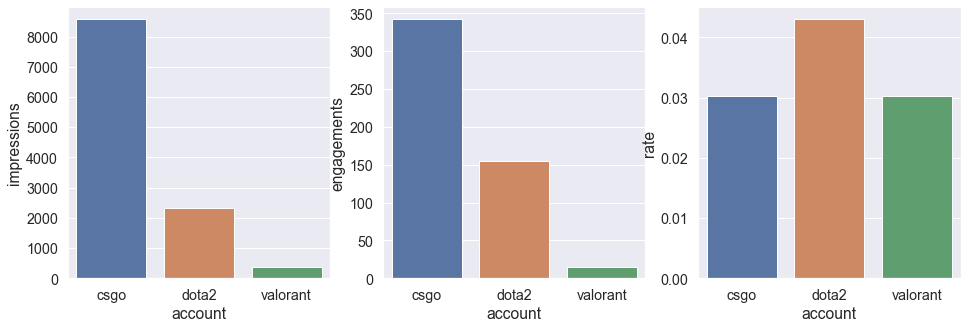

In [90]:
dfd = df[df['account'].isin(games)]
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, metric in zip(axes, metrics):
	plot = sns.barplot(data=dfd, y=metric, x= 'account', ci=None, ax=ax)

CSGO dominantes average impressions and engagements per post but DOTA actually performs the best for engagement rates, which is both impressive given and likely a result of how much more content it gets compared to CSGO and Valorant. And even though Valorant has the smallest average raw numbers, it holds relatively equal to CSGO on engagement rates. Valorant definitely seems like an area where we could focus more. CSGO and DOTA are both somewhat aging properties, and Valorant is a relatively new IP with a lot of ceiling for growth, which seems currently underleveraged.

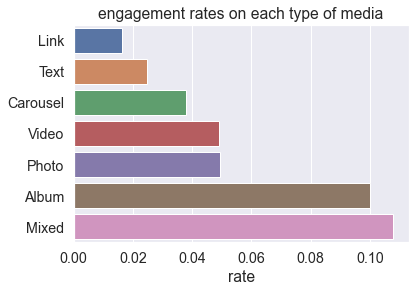

In [91]:
plot = sns.barplot(
    data=df, y='media', x='rate', order=df.groupby('media').mean()['rate'].sort_values().reset_index()['media'], ci=None
).set(title='engagement rates on each type of media', ylabel=None)

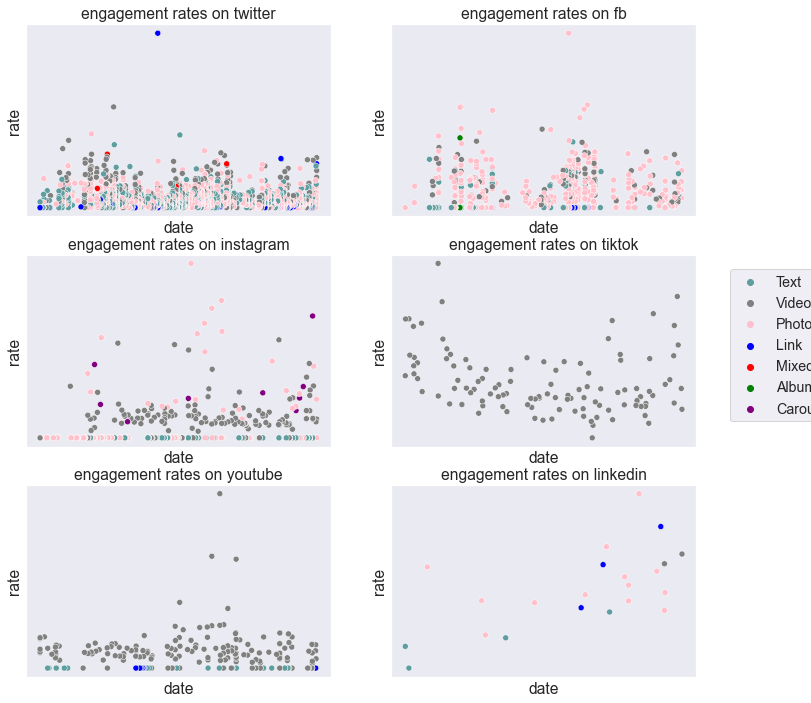

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

medias = df['media'].unique()
colors = ['cadetblue', 'grey', 'pink', 'blue', 'purple', 'red', 'green']
palette = dict(zip(medias, colors))

for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	plot = sns.scatterplot(data=dfd, x='date', y='rate', hue='media', palette=palette, ax=ax)
	axe = ax.get_legend().remove()
	axe = ax.set_title(f"engagement rates on {platform}")
	axe = ax.set_xticks([])
	axe = ax.set_yticks([])

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels, lines = zip(*dict(zip(labels, lines)).items())
fig = fig.legend(lines, labels, loc=(0.9, 0.4))

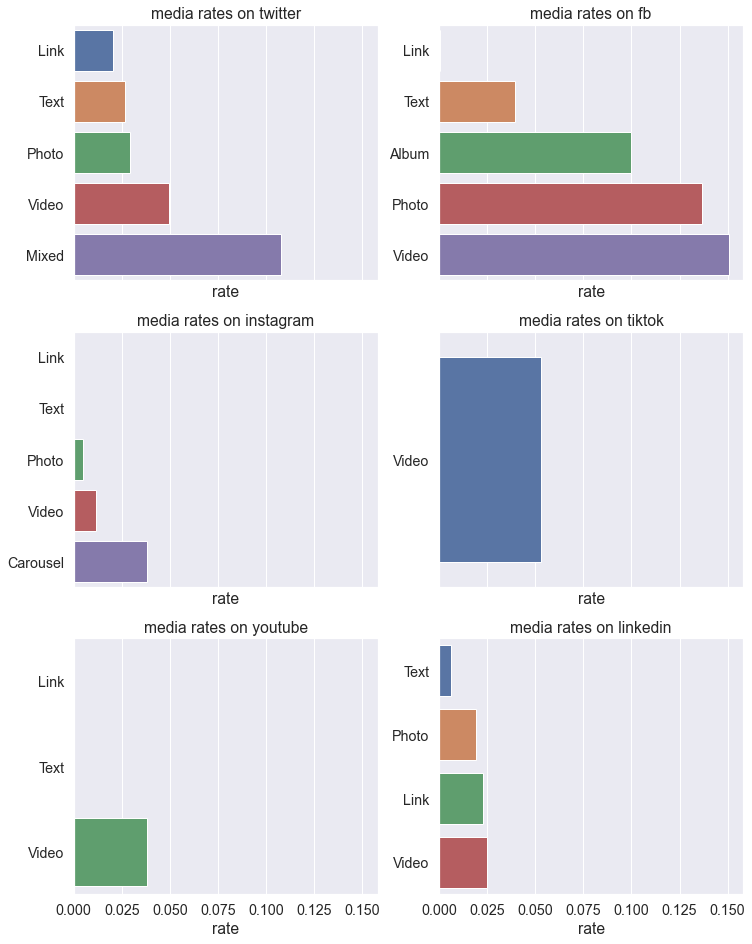

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16), sharex=True)
axes = axes.flatten()

for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	# sns.barplot(data=dfd, y='media', x='rate', ax=ax, ci=None)
	plot = sns.barplot(data=dfd, y='media', x='rate', order=dfd.groupby('media').mean()['rate'].sort_values().reset_index()['media'], ci=None, ax=ax)
	axe = ax.set_title(f"media rates on {platform}")
	axe = ax.set(ylabel=None)

<AxesSubplot:xlabel='impressions', ylabel='platform'>

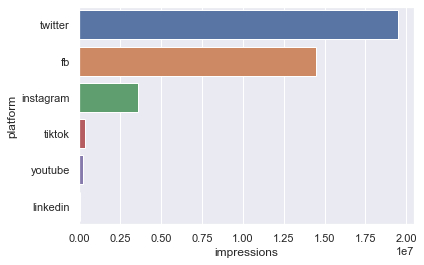

In [39]:
sum_impression_plot = sns.barplot(data=df, y='platform', x='impressions', estimator=sum, ci=None)

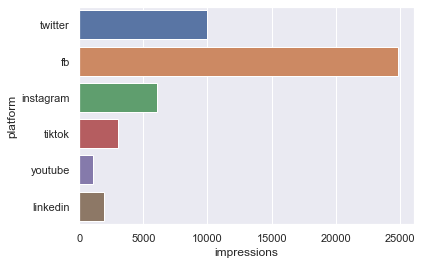

In [40]:
mean_impression_plot = sns.barplot(data=df, y='platform', x='impressions', ci=None)